In [ ]:
from Data.load import load
from Architectures.AE import AE
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import accuracy_score

The idea of this notebook is to show the information density of each band of frequencies in the fourier transformed frequency representation of an MRI scan to gain insight into which scale of reconstruction detail is necessary to achieve a good latent representation of the encoded scans. To do this, we can see how accuracy of a classifier behaves as we mask out certain frequencies, similar to how PFI removes information and looks at the results.

In [18]:
images = load(take=20, train_test_split=1) # Since training on the entire dataset would take too much time

Loading images: 100%|██████████| 20/20 [00:10<00:00,  1.92it/s]


In [147]:
labels = np.stack([[1,0] for i in images])
labels.shape

(20, 2)

In [ ]:
def mask_freq_band(im, band_low, band_high):
    # Compute the 3D FFT of the image
    fft_im = np.fft.fftn(im)
    fft_shift = np.fft.fftshift(fft_im)
    
    # Get frequency grid
    shape = im.shape
    x = np.fft.fftfreq(shape[0])
    y = np.fft.fftfreq(shape[1])
    z = np.fft.fftfreq(shape[2])
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')
    freq_magnitude = np.sqrt(X**2 + Y**2 + Z**2)
    
    # Create mask
    mask = (freq_magnitude < band_low) | (freq_magnitude > band_high)
    
    # Apply mask
    fft_shift *= mask
    
    # Inverse FFT to reconstruct image
    fft_im = np.fft.ifftshift(fft_shift)
    filtered_im = np.fft.ifftn(fft_im).real
    
    return filtered_im

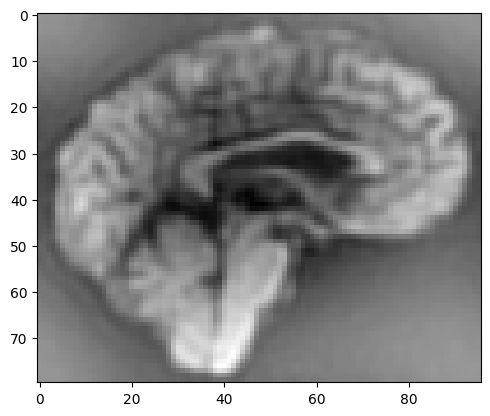

In [100]:
im1 = images[2]-mask_freq_band(images[2],0.65,0.85)
plt.imshow(np.rot90(im1[40]),cmap="gray")

C:\Users\PieHu\AppData\Local\Temp\ipykernel_29740\2057645250.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


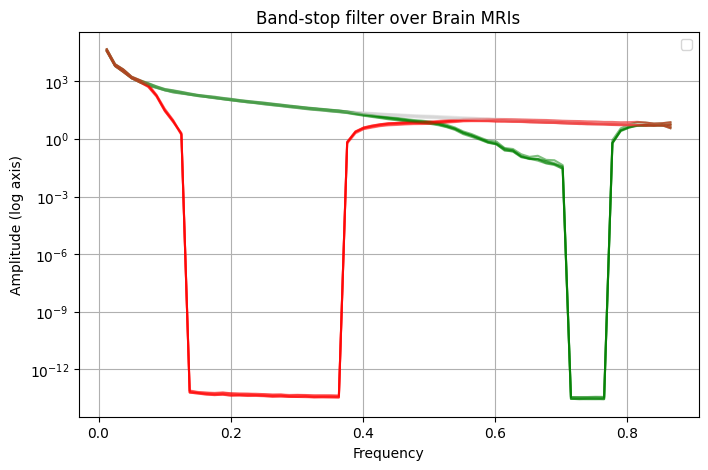

In [124]:
def draw_fft(mri_scan,color=None,alpha=1):
    # Compute the 3D FFT
    fft_result = np.fft.fftn(mri_scan)

    # Compute the amplitude spectrum
    amplitude_spectrum = np.abs(fft_result)

    # Compute frequency bins
    freqs_x = np.fft.fftfreq(mri_scan.shape[0])
    freqs_y = np.fft.fftfreq(mri_scan.shape[1])
    freqs_z = np.fft.fftfreq(mri_scan.shape[2])

    # Compute overall frequency magnitude
    freq_magnitude = np.sqrt(freqs_x[:, None, None]**2 + freqs_y[None, :, None]**2 + freqs_z[None, None, :]**2)

    # Flatten arrays
    freq_magnitude_flat = freq_magnitude.flatten()
    amplitude_flat = amplitude_spectrum.flatten()

    # Bin the data
    bins = np.linspace(0, np.max(freq_magnitude_flat), num=70)
    bin_indices = np.digitize(freq_magnitude_flat, bins)
    binned_amplitude = [amplitude_flat[bin_indices == i].mean() if np.any(bin_indices == i) else 0 for i in range(len(bins))]
    binned_amplitude = np.clip(binned_amplitude, 0, 70_000)
    if color is None:
        plt.plot(bins[1:], binned_amplitude[1:],alpha=alpha)
    else:
        plt.plot(bins[1:], binned_amplitude[1:], color=color,alpha=alpha)

# Plot amplitude vs frequency
plt.figure(figsize=(8, 5))
plt.xlabel("Frequency")
plt.ylabel("Amplitude (log axis)")
plt.title("Band-stop filter over Brain MRIs")

for im in images[:5]:
    draw_fft(im,color="lightgray",alpha=0.5)
    draw_fft(mask_freq_band(im,0.1,0.5),color="green",alpha=0.5)
    draw_fft(mask_freq_band(im,0.5,0.8),color="red",alpha=0.5)
    
plt.yscale("log")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
band_width = 0.3
band_starts = np.linspace(0, 0.9, num=20)
num_freqs = 100  # Assume 100 frequency bins for visualization

# Store classifier scores
scores = []

# Create an empty matrix to track which frequencies are masked in each experiment
M = np.zeros((len(band_starts), num_freqs))

for i, band_start in enumerate(band_starts):
    band_end = band_start + band_width

    # Mask out these frequencies
    images_ = np.stack([mask_freq_band(im, band_start, band_end) for im in images])
    print("Images masked")

    # Train the classifier
    model = models.Sequential([
        layers.Input(shape=(80,96,80,1)),
        layers.Conv3D(5, 3, strides=2),
        layers.Conv3D(20, 3, strides=2),
        layers.Conv3D(50, 3, strides=2),
        layers.Conv3D(90, 3, strides=2),
        layers.Flatten(),
        layers.Dense(labels.shape[1])
    ])
    model.compile(loss="mse", optimizer="adam")
    model.fit(images_, labels, epochs=60)

    # Evaluate performance
    pred = model.predict(images_)
    acc = accuracy_score(np.argmax(labels, axis=1), np.argmax(pred, axis=1))
    scores.append(acc)
    print(f"Accuracy for band ({band_start}, {band_end}): {acc}")

    # Construct the mask matrix M
    start_idx = int(band_start * num_freqs)
    end_idx = min(int(band_end * num_freqs), num_freqs)
    M[i, start_idx:end_idx] = 1  # Mark masked frequencies


Images masked
Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 905ms/step - loss: 0.6837
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.0237
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - loss: 0.2093
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - loss: 0.0494
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0979
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0510
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.0448
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0270
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - loss: 0.0128
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0195
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 0.0238
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 0.0191
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0181
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0152
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0108
Epoch 16/30
1/1 ━━━

KeyboardInterrupt: 

In [ ]:
# Convert scores to a NumPy array
S = np.array(scores)

# Solve for individual frequency importance using least squares
F = np.linalg.pinv(M) @ S

# Plot the feature importance
plt.figure(figsize=(10, 5))
plt.plot(np.linspace(0, 1, num_freqs), F, label="Estimated Feature Importance")
plt.xlabel("Normalized Frequency")
plt.ylabel("Importance Score")
plt.title("Feature Importance Across Frequencies")
plt.legend()
plt.show()